# 사전 학습된 네트워크를 활용하여 모델 훈련시키기
## 1. VGG16 모델
- VGG16은 ImageNet dataset에서 훈련된 합성곱 기반 네트워크로 케라스에 패키지로 포함되어 있다.
- 사전 학습된 모델의 완전 분류기(최상위 Dense 층)는 표현이 일반적이지 않기 때문에 재사용하기 어렵다. 그보다 상대적으로 더 하위 레벨의 합성곱 층들은 이미지의 질감, 색상 등의 더 일반적인 특성을 판단하므로 상대적으로 더 많은 문제에 사용하기 적합하므로 최상위 완전 분류기를 제외한 이 부분만 사용한다.

In [2]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150,3))

In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

## 2. 데이터 증식을 활용하지 않는 빠른 추출
- VGG16 모델을 활용하는 첫번째 방법은 predict 메소드를 이용하여 기존 모델이 예측한 특성을 그대로 레이블에 매치되도록 학습시키는 것이다.
- 추출된 특성은 샘플 하나당 (4, 4, 512) 사이즈 이므로 Dense 층에서 학습시키기 위해 (8192,) 사이즈로 조정한다. 

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '../datasets/small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory( 
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
def save_model(model, history, num=1):
    model.save('cats_and_dogs_small_%d.h5' % num)
    np.save('cats_and_dogs_history_%d.npy' % num,history.history)

- 앞서 직접 CNN을 훈련했던 것과 비슷하게 고양이와 강아지 사진을 분류하기 위한 모델을 구성하고 훈련시킨다. 이때 입력 차원을 아까 추출한 특성 데이터에 맞게 설정해준다.
- Overfitting을 억제하기 위해 최상위 분류기 이전에 Dropout 층을 추가한다.

In [18]:
from tensorflow.keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data = (validation_features, validation_labels))

save_model(model, history, 3)

Epoch 1/30
100/100 [==============================] - 2s 11ms/step - loss: 0.6092 - acc: 0.6610 - val_loss: 0.4422 - val_acc: 0.8340
Epoch 2/30
100/100 [==============================] - 1s 9ms/step - loss: 0.4191 - acc: 0.8170 - val_loss: 0.3648 - val_acc: 0.8530
Epoch 3/30
100/100 [==============================] - 1s 8ms/step - loss: 0.3613 - acc: 0.8405 - val_loss: 0.3319 - val_acc: 0.8610
Epoch 4/30
100/100 [==============================] - 1s 8ms/step - loss: 0.3150 - acc: 0.8635 - val_loss: 0.3065 - val_acc: 0.8760
Epoch 5/30
100/100 [==============================] - 1s 8ms/step - loss: 0.2837 - acc: 0.8825 - val_loss: 0.2979 - val_acc: 0.8730
Epoch 6/30
100/100 [==============================] - 1s 9ms/step - loss: 0.2691 - acc: 0.8860 - val_loss: 0.2792 - val_acc: 0.8930
Epoch 7/30
100/100 [==============================] - 1s 9ms/step - loss: 0.2424 - acc: 0.9060 - val_loss: 0.2663 - val_acc: 0.8960
Epoch 8/30
100/100 [==============================] - 1s 8ms/step - loss: 0

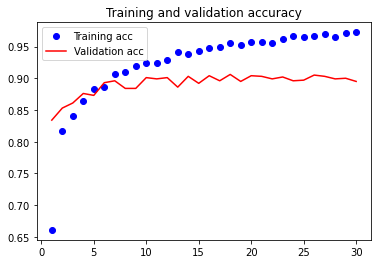

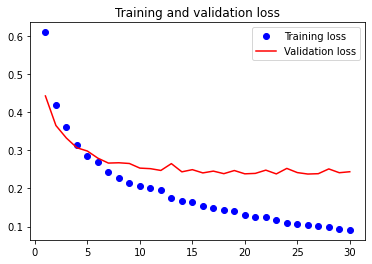

In [19]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 3. 데이터 증식을 활용한 특성 추출
- 앞선 모델의 훈련 결과에서 검증 정확도는 약 90% 정도로, CNN 전체를 처음부터 훈련시키는 방법보다 훨씬 높은 정확도를 보여주고 있다.
- 하지만 0.5 배율의 Dropout을 사용했는데도 불구하고, 학습이 거의 시작되자마자 바로 overfitting이 나타나는 것을 볼 수 있다.
- 훈련 데이터의 수가 적기 때문에 더 많은 훈련 데이터로 ovefitting을 제한하기 위해 데이터를 증식하고, 모델을 구성할 때 층을 추가하듯이 VGG16 모델을 추가하여 입력 데이터와 출력을 end-to-end로 실행한다.

In [21]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_10 (Dense)            (None, 256)               2097408   
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


- 모델에 추가한 VGG16 모델의 층들은 모두 합쳐 14,714,688개나 되는 가중치 파라미터를 가지고 있다. 만약 이 파라미터들을 훈련 과정에서 전부 업데이트하게 된다면, 맨 위의 랜덤하게 초기화된 Dense 층에 의해 매우 큰 변화가 전파되어 기존에 학습된 표현들을 크게 훼손할 것이다.
- 따라서 vgg16 모델로 구성된 층의 trainable 속성을 False로 설정하여 이 부분만 학습이 일어나지 않도록 동결한 뒤, ImageDataGenerator를 활용하여 훈련 데이터만 랜덤하게 변형시킨 형태로 증식하여 훈련을 진행한다.

In [23]:
print('Number of trainable parameters before freezing conv_base:', len(model.trainable_weights))
conv_base.trainable = False
print('Number of trainable parameters after freezing conv_base:', len(model.trainable_weights))
model.summary()

Number of trainable parameters before freezing conv_base: 4
Number of trainable parameters after freezing conv_base: 4
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_10 (Dense)            (None, 256)               2097408   
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [28]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=2e-5), metrics=['acc'])

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 25s 239ms/step - loss: 0.5400 - acc: 0.7535 - val_loss: 0.4340 - val_acc: 0.8160
Epoch 2/30
100/100 [==============================] - 23s 233ms/step - loss: 0.4156 - acc: 0.8305 - val_loss: 0.3365 - val_acc: 0.8790
Epoch 3/30
100/100 [==============================] - 23s 233ms/step - loss: 0.3501 - acc: 0.8565 - val_loss: 0.3010 - val_acc: 0.8850
Epoch 4/30
100/100 [==============================] - 24s 237ms/step - loss: 0.3246 - acc: 0.8680 - val_loss: 0.2811 - val_acc: 0.8960
Epoch 5/30
100/100 [==============================] - 24s 235ms/step - loss: 0.3015 - acc: 0.8755 - val_loss: 0.2677 - val_acc: 0.8960
Epoch 6/30
100/100 [==============================] - 24s 236ms/step - loss: 0.2846 - acc: 0.8855 - val_loss: 0.2601 - val_acc: 0.8990
Epoch 7/30
100/100 [==============================] - 23s 234ms/step - loss: 0.2702 - acc: 0.8885 - val_lo

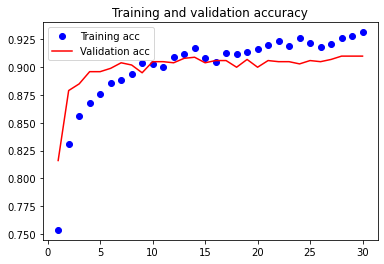

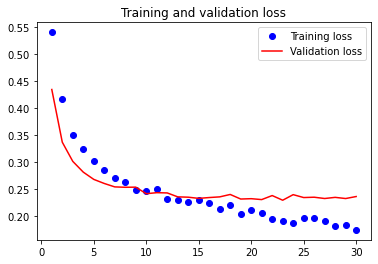

In [29]:
save_model(model, history, 3)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

- 훈련 결과 단순히 특성을 추출한 결과를 학습시킨 것 보다 훨씬 overfitting이 억제된 것을 볼 수 있다.